In [1]:
import sys
sys.path.append('drive/cyclegan_proj/')

In [3]:
from inception import InceptionSham
from data_sampler import SequentialSampler, BatchSampler, RandomSampler
from loss import compute_loss
from loss import consensus_loss
from inception import inception_score
import networks as net
from data_sampler import data_sampler
from utl import *

import numpy as np
import pandas as pd
from math import ceil

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
import datetime as dt
from IPython.display import clear_output

In [7]:
inception_model = InceptionSham(num_classes=10, input_nc=1, dropout=0.5)
if torch.cuda.is_available():
    inception_model.cuda()
inception_state = torch.load("trained_models/inception_sham_state.pth",)
inception_model.load_state_dict(inception_state)

FileNotFoundError: [Errno 2] No such file or directory: 'trained_models/inception_sham_state.pth'

In [8]:
input_nc = 1
output_nc = 1
discr_filters = 8
max_power = 8
n_layers = 2
norm_lay = nn.BatchNorm2d
start_size = 28
gen_filters = 8
dropout = 0.5
n_blocks = 2
batch_size = 5
alpha = 10

In [10]:
train_pull = pd.read_csv("../../data/fashion_mnisit/train_pull.csv", header=None).values
train_top = pd.read_csv("../../data/fashion_mnisit/train_top.csv", header=None).values
test_pull = pd.read_csv("../../data/fashion_mnisit/test_pull.csv", header=None).values
test_top = pd.read_csv("../../data/fashion_mnisit/test_top.csv", header=None).values
train_n_obs = train_pull.shape[0]
test_n_obs = test_pull.shape[0]

In [16]:
discr_a = net.Discriminator(input_nc=input_nc,
                            discr_filters=discr_filters,
                            max_power=max_power,
                            n_layers=n_layers,
                            norm_lay=norm_lay,
                            start_size=start_size
)

discr_b = net.Discriminator(input_nc=input_nc,
                            discr_filters=discr_filters,
                            max_power=max_power,
                            n_layers=n_layers,
                            norm_lay=norm_lay,
                            start_size=start_size
)

gener_a = net.ResnetGenerator(
    input_nc = input_nc,
    output_nc = output_nc,
    gen_filters = gen_filters,
    norm_lay = norm_lay,
    dropout = dropout,
    n_blocks = n_blocks
)

gener_b = net.ResnetGenerator(
    input_nc = input_nc,
    output_nc = output_nc,
    gen_filters = gen_filters,
    norm_lay = norm_lay,
    dropout = dropout,
    n_blocks = n_blocks
)

if torch.cuda.is_available():
    discr_a.cuda()
    discr_b.cuda()
    gener_a.cuda()
    gener_b.cuda()

In [7]:
gener_a.apply(weights_init)
gener_b.apply(weights_init)
discr_a.apply(weights_init)
discr_b.apply(weights_init)
print("weights initialized")

weights initialized


In [8]:
from itertools import chain
adam_params = dict(lr=0.0002, betas=(0.5, 0.999))
opt_discr = torch.optim.Adamax(chain(discr_a.parameters(), 
                                   discr_b.parameters()),
                            **adam_params)
opt_gener = torch.optim.Adamax(chain(gener_a.parameters(),
                                   gener_b.parameters()), 
                            **adam_params)
opt_gener_a = torch.optim.Adam(gener_a.parameters(), **adam_params)
opt_gener_b = torch.optim.Adam(gener_b.parameters(), **adam_params)
opt_discr_a = torch.optim.Adam(discr_a.parameters(), **adam_params)
opt_discr_b = torch.optim.Adam(discr_b.parameters(), **adam_params)

In [9]:
ga_loss_log, gb_loss_log = [], []
da_loss_log, db_loss_log = [], []

da_grad_log, db_grad_log = [], []
ga_grad_log, gb_grad_log = [], []

incp_a_log, incp_b_log = [], []

In [ ]:
# consensus weight
clambda = 1/2

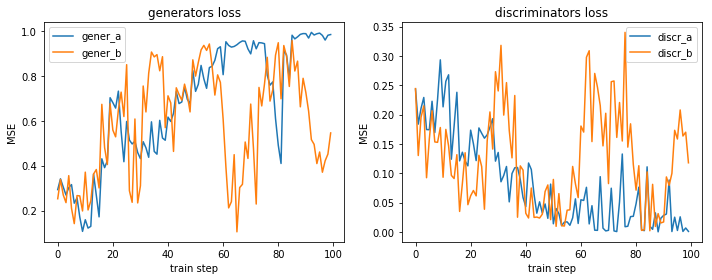

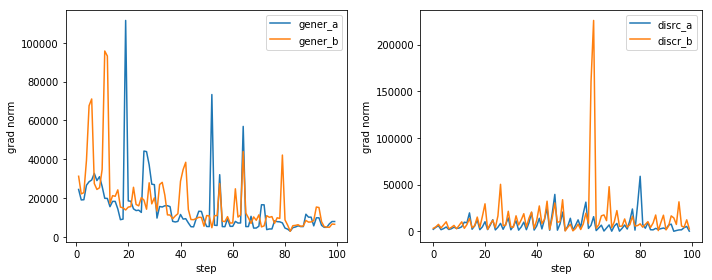

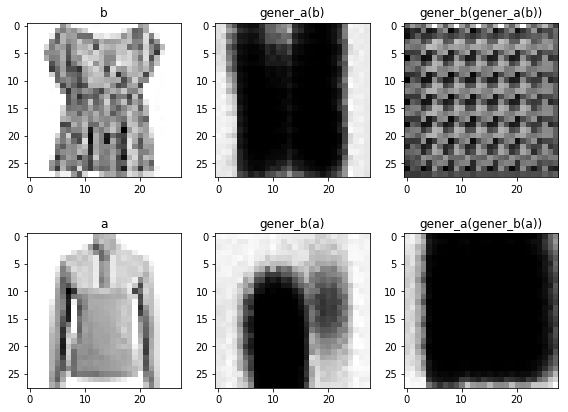

In [11]:
N_EPOCHS = 5

print("Start")
for epoch in range(N_EPOCHS):

    sampler = RandomSampler(train_n_obs)
    batch_sampler_a = BatchSampler(sampler, batch_size)
    batch_sampler_b = BatchSampler(sampler, batch_size)

    for i, batches in enumerate(zip(batch_sampler_a, batch_sampler_b)):
        batch_a = Variable(
            aduc(
                torch.FloatTensor(train_pull[batches[0]]).view(-1, 1, 28, 28)),
            requires_grad=False)
        batch_b = Variable(
            aduc(torch.FloatTensor(train_top[batches[1]]).view(-1, 1, 28, 28)),
            requires_grad=False)

        train_stage(gener_a, gener_b, discr_a, discr_b)

        losses = compute_combined_loss(
            gener_a, gener_b,
            discr_a, discr_b,
            batch_a, batch_b,
            alpha,
            discr_loss='mse',
            use_gpu=True)

        discr_loss, gener_loss = losses[0:2]
        da_loss, db_loss = losses[2:4]
        ga_loss, gb_loss = losses[4:6]
        ga_fool, gb_fool = losses[6:8]

        if i % 4 == 0:
            opt_discr.zero_grad()
            discr_loss.backward()
            opt_discr.step()
        else:
            opt_gener.zero_grad()
            gener_loss.backward()
            opt_gener.step()

#     discr_a_mega_loss = da_loss - clambda * consensus_loss(da_loss, discr_a)
#     discr_b_mega_loss = db_loss - clambda * consensus_loss(db_loss, discr_b)
#     gener_a_mega_loss = ga_loss - clambda * consensus_loss(ga_loss, gener_a)
#     gener_b_mega_loss = gb_loss - clambda * consensus_loss(gb_loss, gener_b)

#     opt_gener_a.zero_grad()
#     opt_gener_b.zero_grad()
#     opt_discr_a.zero_grad()
#     opt_discr_b.zero_grad()

#     (-discr_a_mega_loss).backward(retain_graph=True)
#     (-discr_b_mega_loss).backward(retain_graph=True)
#     (-gener_a_mega_loss).backward(retain_graph=True)
#     (-gener_b_mega_loss).backward()

#     opt_gener_a.step()
#     opt_gener_b.step()
#     opt_discr_a.step()
#     opt_discr_b.step()

        ga_loss_log.append(ga_fool.data[0])
        gb_loss_log.append(gb_fool.data[0])
        da_loss_log.append(da_loss.data[0])
        db_loss_log.append(db_loss.data[0])

        da_grad_log.append(grad_norm(discr_a))
        db_grad_log.append(grad_norm(discr_b))
        ga_grad_log.append(grad_norm(gener_a))
        gb_grad_log.append(grad_norm(gener_b))

        if i % 10 == 0:
            incp_a, incp_b = inception_score(
                gener_a, gener_b,
                inception_model,
                test_pull, test_top,
                batch_size=100,
                splits=10)

            incp_a_log.append(incp_a)
            incp_b_log.append(incp_b)

    # visualize every epoch
        if (i + 1) % 500 == 0:
            clear_output()
            print("Epoch {}".format(epoch + 1))

            plt.figure(figsize=(5, 3))
            plt.plot(incp_a_log, label="gener_a")
            plt.plot(incp_b_log, label="gener_b")
            plt.title('Inception score')
            plt.legend()
            plt.show()

            sample_a, sample_b = data_sampler(
                1, train_pull, train_top, use_gpu=True)
            visualize_loss(da_loss_log, db_loss_log,
                           ga_loss_log, gb_loss_log,
                           exp_window=None)
            plot_grad_norms(da_grad_log, db_grad_log,
                            ga_grad_log, gb_grad_log)
            plot_geners(sample_a, sample_b,
                        gener_a, gener_b)